In [ ]:

import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [ ]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

In [ ]:
import tensorflow as tf
dataset_path = "/content/drive/MyDrive/PlantVillage"

IMAGE_SIZE = (256,256)
BATCH_SIZE = 32
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    seed=123,
    shuffle=True,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,

)
# dataset = tf.keras.preprocessing.image_dataset_from_directory(
#     "/content/drive/MyDrive/PlantVillage",
#     seed=123,
#     shuffle=True,
#     image_size=(IMAGE_SIZE,IMAGE_SIZE),
#     batch_size=BATCH_SIZE
# )

Found 1910 files belonging to 3 classes.


In [ ]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [ ]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[0 0 0 1 1 1 1 1 0 0 0 1 1 0 2 1 0 1 1 0 0 1 1 1 0 1 1 0 2 0 0 1]


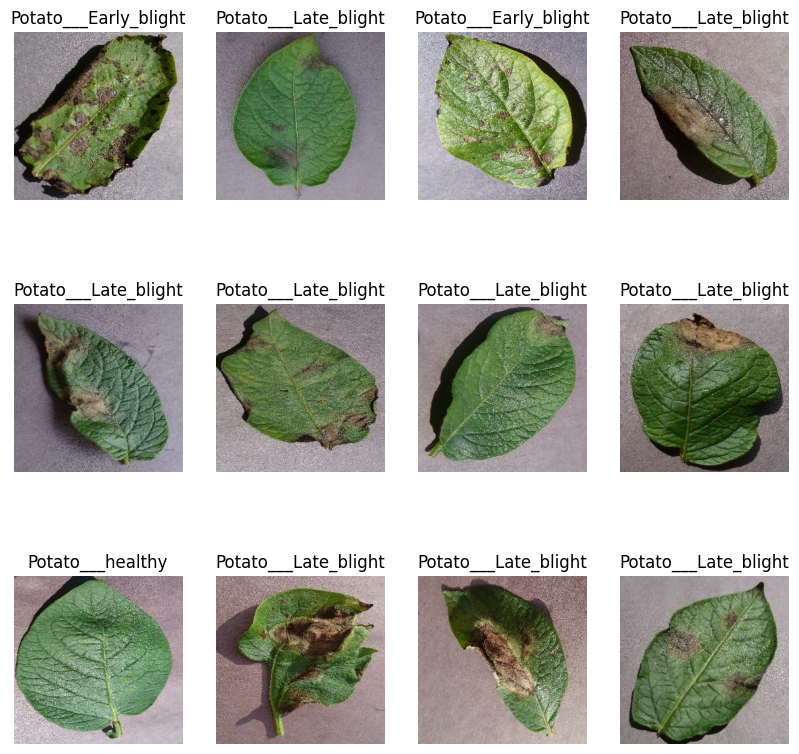

In [ ]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [ ]:
len(dataset)

60

In [ ]:
train_size = 0.8
len(dataset)*train_size

48.0

In [ ]:
train_ds = dataset.take(48)
len(train_ds)

48

In [ ]:
test_ds = dataset.skip(48)
len(test_ds)

12

In [ ]:
val_size=0.1
len(dataset)*val_size

6.0

In [ ]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [ ]:
test_ds = test_ds.skip(6)
len(test_ds)

6

In [ ]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [ ]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [ ]:
len(train_ds)

48

In [ ]:
len(val_ds)

6

In [ ]:
len(test_ds)

6

In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [ ]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [ ]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
# Ensure IMAGE_SIZE and CHANNELS are defined correctly
IMAGE_SIZE = 256
CHANNELS = 3

# Make sure input_shape is defined correctly
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

# Create the model
model = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

# Print the model summary
model.summary()


Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_54 (Conv2D)          (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_54 (MaxPooli  (None, 127, 127, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_55 (Conv2D)          (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_55 (MaxPooli  (None, 62, 62, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_56 (Conv2D)          (None, 60, 60, 64)        36928     
                                                                 
 max_pooling2d_56 (MaxPooli  (None, 30, 30, 64)      

In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
48/48 [==============================] - 536s 4s/step - loss: 2.2757 - accuracy: 0.4895 - val_loss: 0.8061 - val_accuracy: 0.6562
Epoch 2/50
48/48 [==============================] - 194s 4s/step - loss: 0.6598 - accuracy: 0.6782 - val_loss: 0.4544 - val_accuracy: 0.8021
Epoch 3/50
48/48 [==============================] - 193s 4s/step - loss: 0.4289 - accuracy: 0.8119 - val_loss: 0.3581 - val_accuracy: 0.8698
Epoch 4/50
48/48 [==============================] - 200s 4s/step - loss: 0.3336 - accuracy: 0.8604 - val_loss: 0.3122 - val_accuracy: 0.8854
Epoch 5/50
48/48 [==============================] - 192s 4s/step - loss: 0.2442 - accuracy: 0.9096 - val_loss: 0.1789 - val_accuracy: 0.9375
Epoch 6/50
48/48 [==============================] - 194s 4s/step - loss: 0.1792 - accuracy: 0.9345 - val_loss: 0.2100 - val_accuracy: 0.9375
Epoch 7/50
48/48 [==============================] - 195s 4s/step - loss: 0.1858 - accuracy: 0.9260 - val_loss: 0.2500 - val_accuracy: 0.9115
Epoch 8/50
48

In [ ]:
scores = model.evaluate(test_ds)

6/6 [==============================] - 15s 1s/step - loss: 0.0322 - accuracy: 0.9896


In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

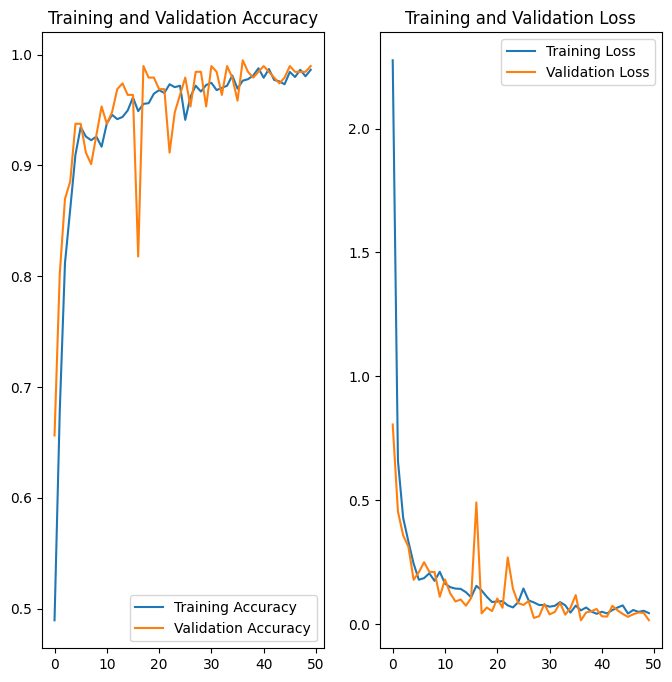

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Potato___Early_blight
1/1 [==============================] - 1s 1s/step
predicted label: Potato___Early_blight


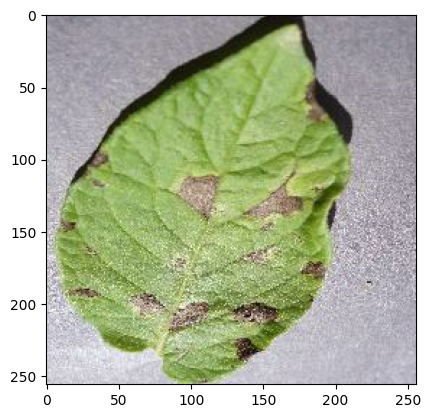

In [ ]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 49ms/step


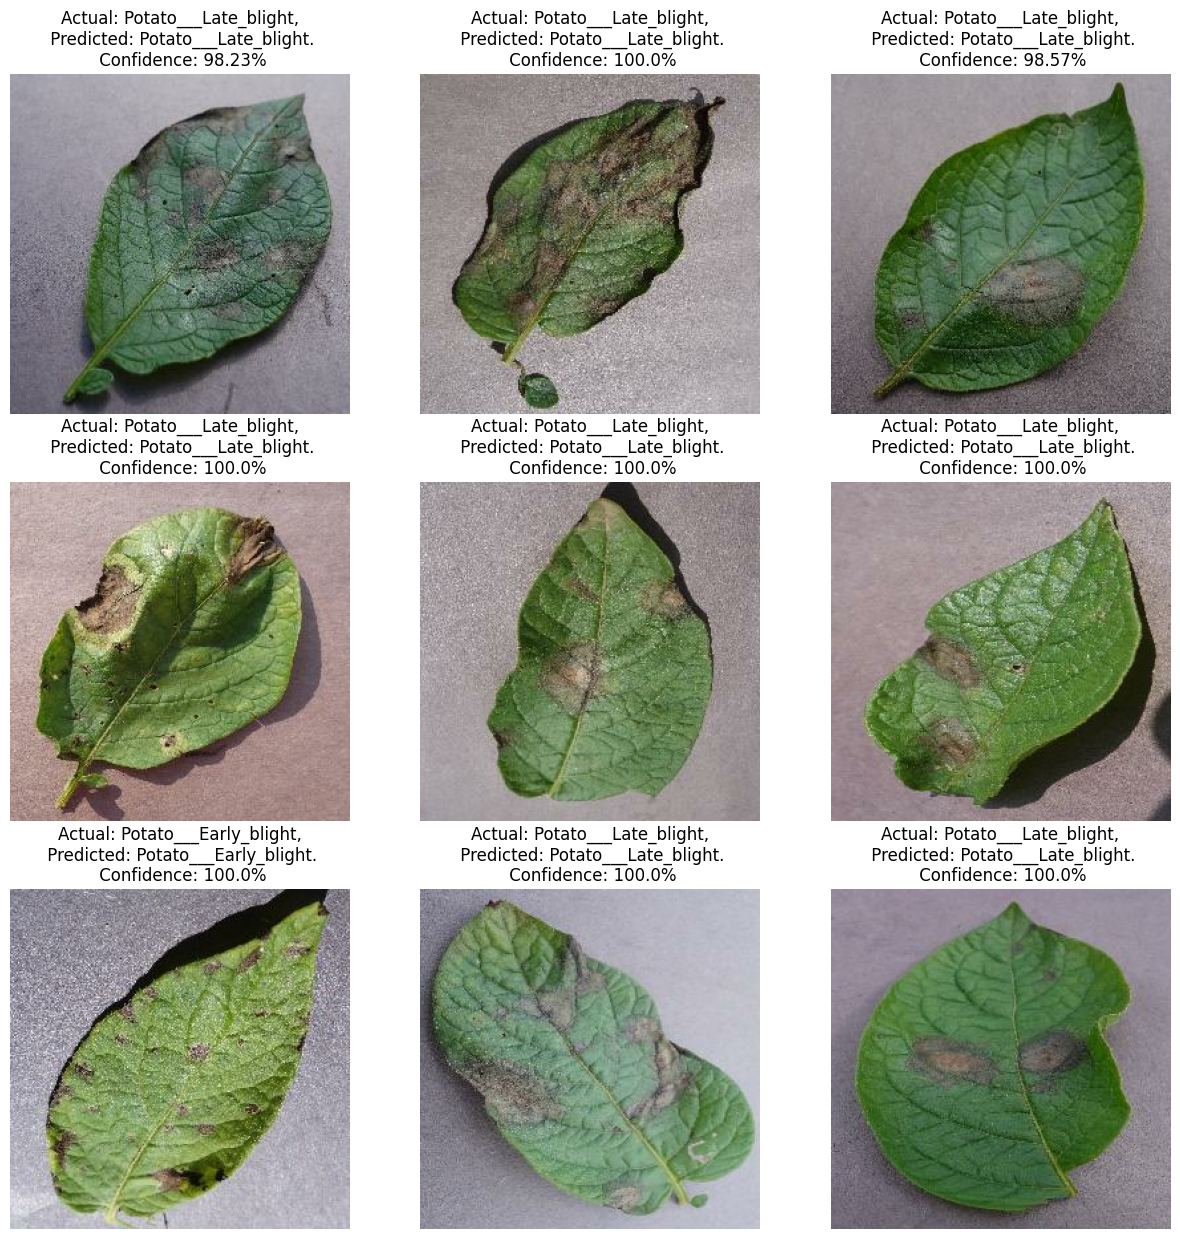

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

In [ ]:
from tensorflow.keras.models import load_model
model.save('/content/drive/MyDrive/Saved Models/leafmodel')


NameError: name 'model' is not defined

In [ ]:
tf.keras.models.save_model(model,'my_model2.hdf5')

<ipython-input-104-07e813155dae>:1: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model,'my_model2.hdf5')


In [ ]:
model.save

In [ ]:
!pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 22.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 26.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 51.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.0/83.0 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.7 MB/s eta 0:00:00


In [ ]:
%%writefile app.py

import streamlit as st
import tensorflow as tf
import streamlit as st


@st.cache(allow_output_mutation=True)
def load_model():
  model=tf.keras.models.load_model('/content/my_model2.hdf5')
  return model
with st.spinner('Model is being loaded..'):
  model=load_model()

st.write("""
         # Flower Classification
         """
         )

file = st.file_uploader("Please upload an brain scan file", type=["jpg", "png"])
import cv2
from PIL import Image, ImageOps
import numpy as np
st.set_option('deprecation.showfileUploaderEncoding', False)
def import_and_predict(image_data, model):

        size = (256,256)
        image = ImageOps.fit(image_data, size, Image.ANTIALIAS)
        image = np.asarray(image)
        img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        #img_resize = (cv2.resize(img, dsize=(75, 75),    interpolation=cv2.INTER_CUBIC))/255.

        img_reshape = img[np.newaxis,...]

        prediction = model.predict(img_reshape)

        return prediction
if file is None:
    st.text("Please upload an image file")
else:
    image = Image.open(file)
    st.image(image, use_column_width=True)
    predictions = import_and_predict(image, model)
    score = tf.nn.softmax(predictions[0])
    st.write(prediction)
    st.write(score)
    print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)



Writing app.py


In [ ]:
!pip install pyngrok

In [ ]:
!ngrok authtoken 2eW9xdee2vM7S88vEPbQAqOdiuX_78cktFC1fD4Bg8LXDwgL5

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [ ]:
!nohup streamlit run app.py &

nohup: appending output to 'nohup.out'


In [ ]:
from pyngrok import ngrok

# Set up ngrok tunnel
ngrok_tunnel = ngrok.connect(port=8501)

# Get the public URL of the tunnel
public_url = ngrok_tunnel.public_url
print("Ngrok Tunnel URL:", public_url)


# from pyngrok import ngrok
# url=ngrok.connect(port=8502)
# url


PyngrokNgrokHTTPError: ngrok client exception, API returned 400: {"error_code":102,"status_code":400,"msg":"invalid tunnel configuration","details":{"err":"yaml: unmarshal errors:\n  line 1: field port not found in type config.HTTPv2Tunnel"}}


In [ ]:

!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip

--2024-04-01 22:28:04--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 54.161.241.46, 52.202.168.65, 18.205.222.128, ...
Connecting to bin.equinox.io (bin.equinox.io)|54.161.241.46|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13921656 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  13.28M  17.7MB/s    in 0.8s    

2024-04-01 22:28:05 (17.7 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13921656/13921656]



In [ ]:

!unzip ngrok-stable-linux-amd64.zip

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


In [ ]:
get_ipython().system_raw('./ngrok http 8501 &')

In [ ]:
!curl -s http://localhost:4040/api/tunnels | python3 -c \
'import sys, json; print("Execute the next cell and the go to the following URL:" +json.load(sys.stdin)["tunnels"][0]["public_url"])'


Traceback (most recent call last):
  File "<string>", line 1, in <module>
IndexError: list index out of range


In [ ]:
!streamlit run /content/app.py





  You can now view your Streamlit app in your browser.

  Network URL: http://172.28.0.2:8502
  External URL: http://34.125.211.1:8502

  Stopping...
^C
